1. 데이터 로드
전북 군산 지역의 생산량과 환경 데이터를 CSV 파일에서 불러옴. 생산량은 목표 변수로 사용되고, 환경 데이터는 예측에 사용될 특징 데이터

In [93]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# CSV 파일에서 생산량 데이터와 환경 데이터를 로드
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')


2. 날짜 데이터 변환 및 주차 계산
환경 데이터의 날짜는 'measDtStr'이라는 열에 있음. 
이를 datetime 형식으로 변환하여 연도(year)와 주차(week) 정보를 계산. 
주차별 데이터를 사용해 주간 환경 데이터를 생성하는데 활용

In [94]:
# 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

3. 주간 평균 환경 데이터 계산
각 주차별로 온도(inTp), 습도(inHd), 이산화탄소 농도(inCo2)의 평균, 최소, 최대값을 계산하여 주간 환경 데이터를 생성

In [95]:
# 주간 평균, 최소, 최대 환경 데이터 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],  # 온도
    'inHd': ['mean', 'min', 'max'],  # 습도
    'inCo2': ['mean', 'min', 'max']  # CO2 농도
}).reset_index()

# 다중 레벨의 컬럼 이름을 단순화
env_weekly_features.columns = ['_'.join(col).strip('_') for col in env_weekly_features.columns.values] \
#group by 와 agg 함수를 사용해서 [('inTp', 'mean'), ('inTp', 'min'), ('inTp', 'max')] 이런 형식이였던 데이터를 ['inTp_mean', 'inTp_min', 'inTp_max'] 이렇게 변환
env_weekly_features.rename(columns={'연도_': '연도', '주차_': '주차'}, inplace=True)

4. 주차의 주기적 특성 추가
주차(week) 데이터를 주기적으로 처리하기 위해 sine과 cosine 변환을 적용. 주차는 1년을 기준으로 반복되기 때문에, 이러한 변환을 통해 주차별 특성을 효과적으로 반영
주차는 1년을 기준으로 1부터 52까지의 값을 갖는 순환적인 데이터 
주기적인 데이터는 단순히 숫자만으로는 이 주기성을 제대로 반영하지 못할 수 있음. sin과 cos 함수를 사용하면 1년 단위로 반복되는 주기성을 보다 잘 표현

In [96]:
# 주차의 주기적 특성을 반영하는 sine, cosine 값 추가
env_weekly_features['sin_week'] = np.sin(2 * np.pi * env_weekly_features['주차'] / 52)
env_weekly_features['cos_week'] = np.cos(2 * np.pi * env_weekly_features['주차'] / 52)

5. 생산량 데이터 병합 및 결합
생산량 데이터를 환경 데이터와 주차 및 연도 기준으로 병합. 병합 후 결측치를 제거하여 깨끗한 데이터셋을 생성하고, 데이터셋의 크기와 결측치 개수를 확인.

In [97]:
# 생산량 데이터에서 'frmhsId' 열 이름을 수정
yield_data.rename(columns={'item.frmhsId': 'frmhsId'}, inplace=True)

# 환경 데이터와 생산량 데이터를 연도와 주차 기준으로 병합
merged_data = pd.merge(
    env_weekly_features, 
    yield_data[['연도', '주차', '생산량']], 
    on=['연도', '주차'], 
    how='inner'
).dropna(subset=['생산량'])

# 병합된 데이터의 결측치 및 길이 확인
print(f"merged_data의 길이: {len(merged_data)}")
print(f"결측치 개수: {merged_data.isnull().sum()}")


merged_data의 길이: 42
결측치 개수: 연도            0
주차            0
inTp_mean     0
inTp_min      0
inTp_max      0
inHd_mean     0
inHd_min      0
inHd_max      0
inCo2_mean    0
inCo2_min     0
inCo2_max     0
sin_week      0
cos_week      0
생산량           0
dtype: int64


6. 특성과 타겟 변수 준비 및 표준화
 입력 데이터(X)와 타겟 데이터(y)를 준비
 특성 데이터는 표준화를 적용하고, 타겟 데이터는 MinMaxScaler로 정규화

In [98]:
# 사용할 특성(feature)과 타겟(target) 변수 준비
features = ['sin_week', 'cos_week'] + merged_data.columns[2:-1].tolist()
X = merged_data[features].values
y = merged_data['생산량'].values

# 입력 데이터(X)를 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터(y)를 MinMaxScaler로 정규화
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

7. 시계열 데이터 준비
시계열 데이터는 4주 동안의 데이터를 입력으로 사용하고, 다음 주 생산량을 예측하는 방식으로 준비. 이를 통해 각 시퀀스를 만들고, 데이터를 학습과 테스트 세트로 나눔.

In [99]:
# 4주 동안의 데이터를 사용하여 다음 주 생산량을 예측하기 위한 시퀀스 생성
timesteps = 4  # 4주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성합니다.
X_sequences = []
y_sequences = []

for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps])
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

8. 모델 구축
LSTM과 GRU 레이어를 결합한 시계열 예측 모델을 구성
과적합을 방지하기 위해 드롭아웃을 추가

In [100]:
# LSTM-GRU 모델 구축
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, 
                         kernel_regularizer=tf.keras.regularizers.l2(0.001), 
                         input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, 
                         kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.GRU(50, activation='relu'),  # GRU 층 추가
    tf.keras.layers.Dropout(0.3),  # 과적합 방지를 위한 드롭아웃
    tf.keras.layers.Dense(forecast_weeks)  # 예측할 주차 수 만큼의 출력 뉴런
])


c:\Users\a\anaconda3\envs\jungwoo\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9. 모델 컴파일 및 학습
MSprop 최적화 알고리즘을 사용해 컴파일하며, MSE(평균 제곱 오차) 손실함수를 사용
EarlyStopping을 설정해 학습이 진행되면서 성능이 개선되지 않을 경우 학습을 조기에 종료


In [101]:
# RMSprop 최적화 알고리즘으로 모델 컴파일
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# EarlyStopping 콜백 설정 (검증 손실이 10번 연속으로 개선되지 않으면 학습 중단)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습 (100 에포크, 배치 사이즈 32)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# 테스트 데이터로 모델 평가
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4513 - mae: 0.4239 - val_loss: 0.4719 - val_mae: 0.4320
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.4185 - mae: 0.4008 - val_loss: 0.4469 - val_mae: 0.4218
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3946 - mae: 0.3863 - val_loss: 0.4261 - val_mae: 0.4118
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3778 - mae: 0.3712 - val_loss: 0.4068 - val_mae: 0.4011
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3417 - mae: 0.3381 - val_loss: 0.3868 - val_mae: 0.3890
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3264 - mae: 0.3234 - val_loss: 0.3701 - val_mae: 0.3775
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3177 - mae: 0.3146 - val_loss: 0.3553 - val_mae: 0.3665
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2832 - mae: 0.2628 - val_loss: 0.3424 - val_mae: 0.3539
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2761 - mae: 0.

10. 테스트 및 결과 확인

In [102]:
# 전체 데이터를 다시 사용하여 예측하기 위해 X_sequences와 y_scaled를 기반으로 전체 데이터를 예측
y_pred_full_scaled = model.predict(X_sequences)
y_pred_full = scaler_y.inverse_transform(y_pred_full_scaled)

# 전체 데이터에 대한 실제 생산량의 총합 계산
total_actual_production_full = scaler_y.inverse_transform(y_scaled).sum()

# 전체 데이터에 대한 예측 생산량의 총합 계산
total_predicted_production_full = y_pred_full.sum()

# 전체 데이터에 대한 실제 생산량과 예측 생산량 출력
print(f"총 실제 생산량 (전체 데이터): {total_actual_production_full}")
print(f"총 예측 생산량 (전체 데이터): {total_predicted_production_full}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
총 실제 생산량 (전체 데이터): 200026.0
총 예측 생산량 (전체 데이터): 196635.359375


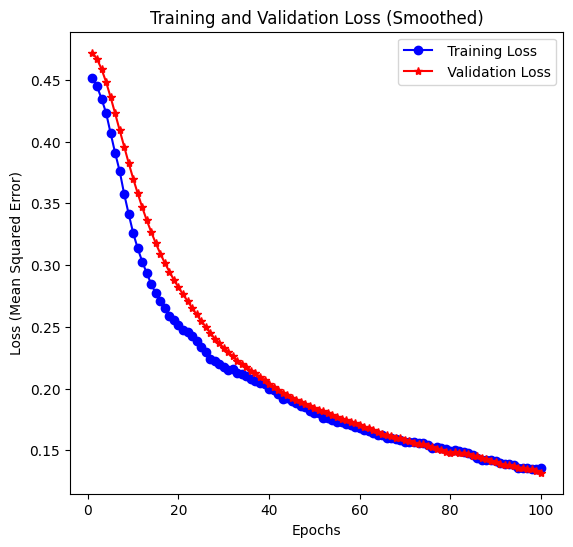

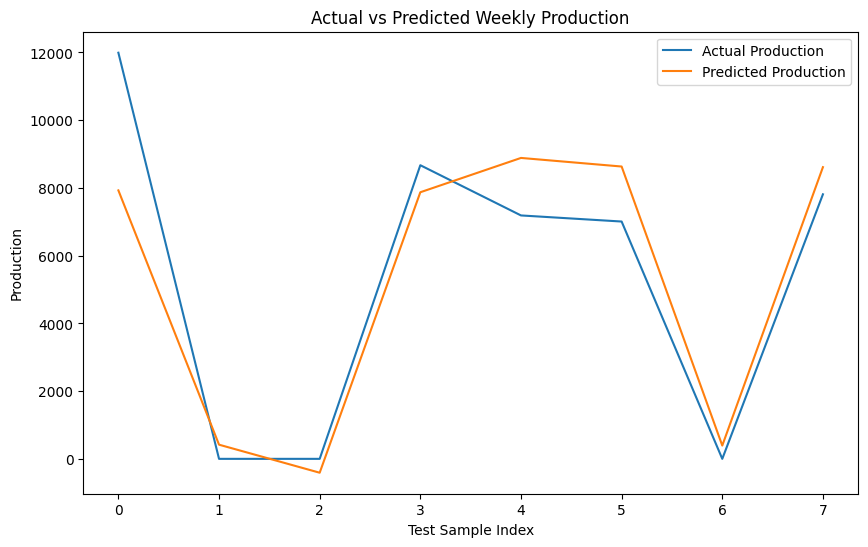

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 이력에서 손실값과 MAE를 가져옴
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']
epochs = range(1, len(loss) + 1)

# 이동 평균을 사용하여 곡선 스무딩 함수
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# 손실 그래프
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(loss), 'bo-', label=' Training Loss')
plt.plot(epochs, smooth_curve(val_loss), 'r*-', label=' Validation Loss')
plt.title('Training and Validation Loss (Smoothed)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()

# 실제 생산량 vs 예측 생산량 비교 그래프
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse.flatten(), label='Actual Production')
plt.plot(y_pred.flatten(), label='Predicted Production')
plt.title('Actual vs Predicted Weekly Production')
plt.xlabel('Test Sample Index')
plt.ylabel('Production')
plt.legend()

plt.show()
